# Swift UVOT Events

## Reading in Data

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries
from astropy.timeseries import aggregate_downsample
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS

from regions import CircleSkyRegion
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import wget

In [3]:
## Run this to download the files locally.

eventDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/event/sw00094137009um2w1po_uf.evt.gz'
imgDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/products/sw00094137009u_sk.img.gz'

eventPath = 'sw00094137009um2w1po_uf.evt.gz'
imgPath = 'sw00094137009u_sk.img.gz'

try:
    wget.download(eventDataUrl, eventPath)
    wget.download(imgDataUrl, imgPath)
    print('Downloaded files')
    
except:
    print('Error downloading files')

  2% [.                                                   ]  1695744 / 79529450Error downloading files


In [4]:
## Open files after downloading them locally. No need to change the file path.

eventFile = fits.open('sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [382]:
print(events)

[(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0)
 (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0)
 (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0) ...
 (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256)
 (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256)
 (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)]


In [6]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166


## Cleaning Event Data

In [7]:
events_good = events[np.where((events.QUALITY == 0))]
## quality flag of 0 = good
print(f'removed {len(events) - len(events_good)} events')

removed 1952995 events


In [402]:
## Removing non-continuous data points (or floating chunks of data)

events_good.sort()
events_int = [tuple(events_good[0])]
waiting_interval = []

formats = events_good.dtype

eStart = events_good['TIME'][0]
eLast = events_good['TIME'][0]

for i in range(1, len(events_good)):
    eTime = events_good['TIME'][i]
    if (eTime - eLast < 5):
        # print('flag')
        waiting_interval.append(tuple(events_good[i]))
        eLast = eTime
    else:
        # print('flag 2')
        ## end the interval
        if (eTime - eStart > 80): ## interval is large
            events_int += waiting_interval
        waiting_interval = []
        eStart = events_good['TIME'][i + 1]
        eLast = events_good['TIME'][i + 1]
            
events_clean = np.array(events_int, dtype=formats)

In [403]:
events_clean = events_clean.view(np.recarray)
len(events_clean)

2982463

## Displaying Event Data

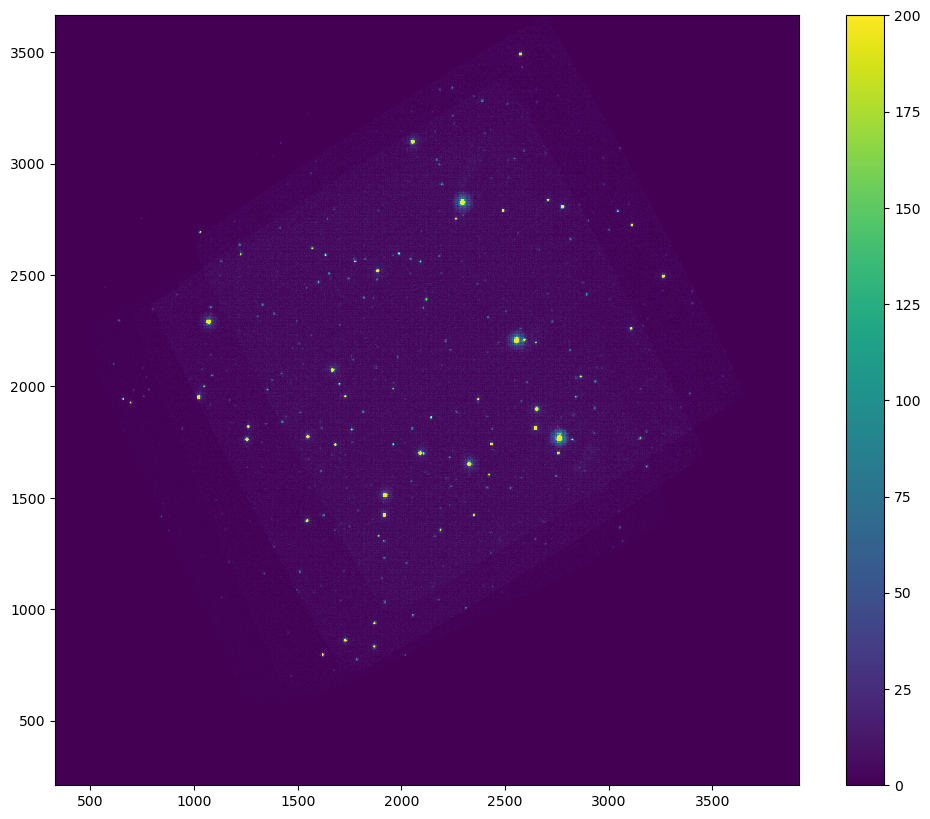

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

#plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()
plt.show()

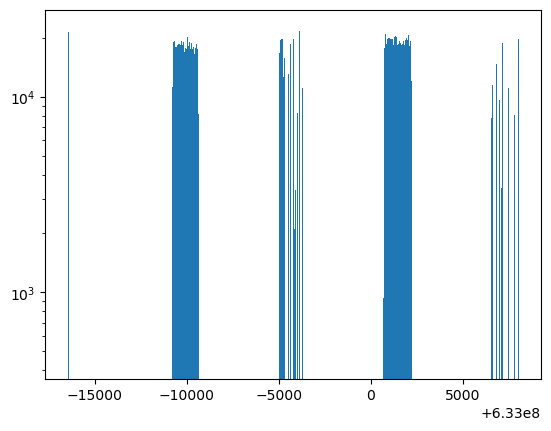

In [404]:
times = plt.hist(events_clean['TIME'], bins=1000, log=True)
plt.show()

## Star-finding

In [405]:
## import annulus
from PIL import Image
im_frame = Image.open('annuli_imgs/annulus_22.png')
## these stars are smaller, so we use the smaller annulus

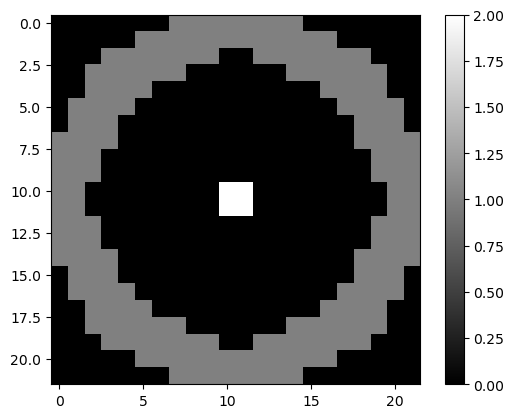

In [406]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

## fix up imported annulus
annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star (circle aperture)
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()
plt.show()

### Signal to Noise Ratio

In [14]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

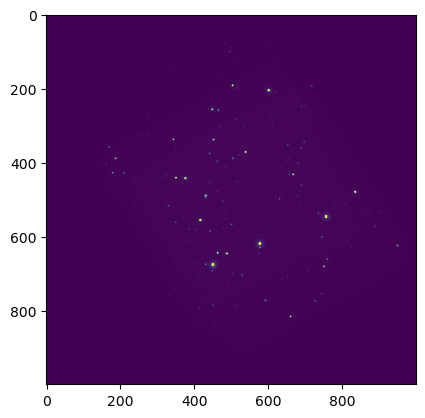

In [15]:
testImg = histdata
plt.imshow(testImg, vmin=0, vmax=500)
plt.show()

In [407]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

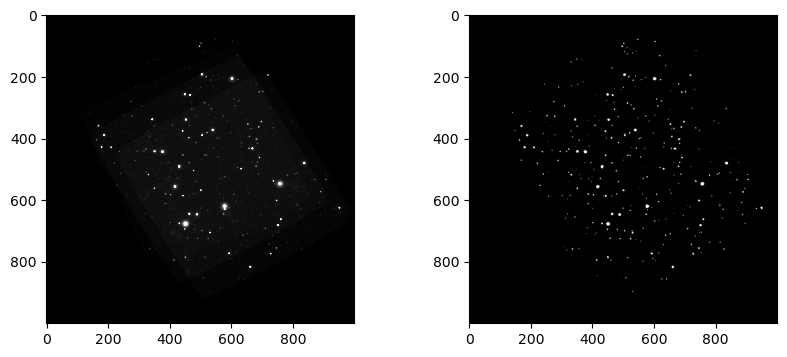

In [408]:
threshold = 5

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=100)
axes[1].imshow(imgCut, cmap='gray')
plt.show()

### Counting the Stars

In [409]:
def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [410]:
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [411]:
print('number of stars:', count)

number of stars: 349


## Star Data
Access stars by coordinates, SNR ratio, and display them by index.

In [412]:
class StarData:
    stars = []
    coords = []
    SNRs = []
    
    def __init__ (self, stars):
        self.stars = stars
        self.coords = [[] for _ in range(len(stars))]
        self.SNRs = [0 for _ in range(len(stars))]
        
        for i in range(len(self.stars)):
            xmin, xmax = 1000, 0
            ymin, ymax = 1000, 0
            snrCount = 0
            for [x, y] in self.stars[i]:
                snrCount += snrImg[x, y]
                if (x > xmax): 
                    xmax = x
                elif (x < xmin):
                    xmin = x
                if (y > ymax):
                    ymax = y
                elif (y < ymin):
                    ymin = y
            starX = int((xmax + xmin)/2)
            starY = int((ymin + ymax)/2)
            
            self.coords[i] = [starX, starY]
            
            self.SNRs[i] = snrCount/len(self.stars[i])
                     
    def getStarByCoord (self, x, y, window=100):
        for i in range(len(self.coords)):
            if (x - window <= self.coords[i][0] <= x + window):
                if (y - window <= self.coords[i][1] <= y + window):
                    print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                     
    def getStarBySnr (self, minSNR, maxSNR=400):
        for i in range(len(self.SNRs)):
            if (minSNR <= self.SNRs[i] <= maxSNR):
                print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                
    def displayStar (self, i, size=15, mode='zoom'): ## mode='whole' shows star in context of whole image
        x, y = self.coords[i]
        print(x, y)
        if (mode == 'zoom'):
            plt.imshow(testImg[x - size:x + size, y - size:y + size], vmin=0, vmax=200, cmap='gray')
        else:
            starCircle = plt.Circle((y, x), size, color='y', fill=False)
            plt.imshow(testImg, vmin=0, vmax=200, cmap='gray')
            plt.gca().add_patch(starCircle)
        plt.show()

## Finding the Changing Event

1) Isolate all the coordinates of individual stars.

2) For each star:
    
    a) Get the star data
    
    b) For each possible size of a signal window:
        
        i) For each possible window in the star data:
        
            Calculate the SNR ratio
            
        ii) Return all timestamps with an outlier SNR ratio
        
    c) Return all signal windows with outlier timestamps

### Isolating Stars
Code and helper function to get a list of all the stars, and index contains a list of the coordinates of the star.

In [413]:
def getStar (matrix, i, j):
    ## initial star has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    return [star, visited]

In [414]:
stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v

In [415]:
starList = StarData(stars)

### Getting Data for a Star
Gets event data for a star based on its coordinates.

In [25]:
def getData (star):
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

### Other Helper Functions

In [26]:
## Visualize the events of a given star
def visualizeStarTS (starData, binsize=5, xmin=632980000, xmax=633020000, windowStart=-1, windowSize=-1, customLim=False, point=False):
    end = Time(max(starData['TIME']), format='gps').fits
    timeBounds = []
    
    if (not customLim and windowStart != -1 and windowSize != -1):
        bgWindow = 1.5 * windowSize
        windowDist = 0.2 * windowSize
        xmin = windowStart - windowDist - bgWindow - 0.25 * windowSize
        xmax = windowStart + windowSize + windowDist + bgWindow + 0.25 * windowSize
        
    for i in range(len(starData['TIME'])):
        if (xmin <= starData['TIME'][i] <= xmax):
            timeBounds.append(starData['TIME'][i])
    
    times = [Time(t, format='gps') for t in timeBounds]
    
    ts = TimeSeries(time=times)
    
    ts['num_events'] = [1 for _ in range(len(ts))]
    
    binnedts = aggregate_downsample(ts, time_bin_size=binsize * u.second, aggregate_func=np.sum)
    
    if (point):
        plt.plot(binnedts.time_bin_start.gps, binnedts['num_events'], 'b.')
    else:
        plt.plot(binnedts.time_bin_start.gps, binnedts['num_events'], 'b-')
    plt.xlim(xmin, xmax)
    plt.ylim(0, max(binnedts['num_events']) + 1)
    
    if (windowStart != -1 and windowSize != -1):
        bgWindow = 1.5 * windowSize
        windowDist = 0.2 * windowSize
        
        plt.axvspan(windowStart, windowStart + windowSize, color='g', alpha=0.5, lw=0)
        
        plt.axvspan(windowStart - windowDist - bgWindow, windowStart - windowDist, color='r', alpha=0.5, lw=0)
        plt.axvspan(windowStart + windowSize + windowDist, windowStart + windowSize + windowDist + bgWindow, 
                    color='r', alpha=0.5, lw=0)
        
    plt.show()
    
    ts.time.format = 'gps'
    binnedts.time_bin_start.format = 'gps'
    return binnedts

In [201]:
## Split mass of data into contiguous intervals.
def splitInterval (starData, windowLength=5):
    starData.sort()
    intervals = []
    interval = [starData[0]]
    for i in range(1, len(starData)):
        if (starData[i] - starData[i - 1] > windowLength):
            if (len(interval) > 0):
                dist = max(interval) - min(interval)
                if (dist >= windowLength * 3.5 and len(interval) > windowLength * 3.5):
                    intervals.append(np.array(interval))
            interval = [starData[i]]
        else:
            interval.append(starData[i])
            
    ## fencepost error!!
    dist = max(interval) - min(interval)
    if (dist >= windowLength * 3.5 and len(interval) > windowLength * 3.5):
        intervals.append(np.array(interval))
    
    return intervals

In [138]:
def getMaxWindow (starData):
    sortedStarData = sorted(starData)
    try:
        ints = splitInterval(starData, 5)
        mins = [min(1000000, ints[i][-1] - ints[i][0]) for i in range(len(ints))]
        return int(max(mins) / 4)
    except:
        return 0

### Calculating SNR Ratio
Input: window size, beginning of signal window timestamp, sorted star data

Output: signal to noise ratio

Guaranteed: beginning of signal window timestamp is inside the sorted star data

In [347]:
def calculateRatio (signalWindow, timeStart, starData, printLog=False):
    ## calculate background window size
    bgWindow = 1.5 * signalWindow ## 1.5 times the length of the signal window on both sides
    windowDist = 0.2 * signalWindow ## distance between bgWindow and signalWindow
    bgArea = 0
    
    ## adding up photon counts
    # signal
    sigLeftMask = starData >= timeStart
    sigRight = starData[sigLeftMask]
    sigRightMask = sigRight <= timeStart + signalWindow
    sig = sigRight[sigRightMask]
    
    signalCounts = len(sig)
    if (signalCounts == 0):
        return 0
    
    # background
    leftBgLeftMask = starData >= timeStart - bgWindow - windowDist
    leftBgLeft = starData[leftBgLeftMask]
    leftBgRightMask = leftBgLeft <= timeStart - windowDist
    leftBg = leftBgLeft[leftBgRightMask]
    
    rightBgLeftMask = starData >= timeStart + signalWindow + windowDist
    rightBgLeft = starData[rightBgLeftMask]
    rightBgRightMask = rightBgLeft <= timeStart + signalWindow + bgWindow + windowDist
    rightBg = rightBgLeft[rightBgRightMask]
    
    bgCounts = len(leftBg) + len(rightBg)
    bgRaw = np.append(leftBg, rightBg)
    
    ## area of bg window
    leftBound = timeStart - bgWindow - windowDist
    rightBound = timeStart + signalWindow + bgWindow + windowDist
    
    if (leftBound < min(starData)):
        bgArea += timeStart - windowDist - min(starData)
    elif (len(leftBg) == 0):
        bgArea += 0
    else:
        bgArea += bgWindow
    
    if (max(starData) < rightBound):
        bgArea += max(starData) - timeStart - signalWindow - windowDist 
    elif (len(rightBg) == 0):
        bgArea += 0
    else:
        bgArea += bgWindow  
    
    if (bgArea == 0):
        return 0
    
    ## np.divide(bgRaw, np.array([max(bgArea, 1) for _ in range(len(bgRaw))]))
    
    ## we are guaranteed signal window is within the data, so signalArea = signalWindow
    
    ## calculating noise
    bgMean = bgCounts/bgArea
    signal = signalCounts/signalWindow - bgMean
    totalNoise = np.std(bgRaw)**2/bgArea
    
    if (printLog):
        print('signalCounts', signalCounts, 'signalArea', signalWindow)
        print('bgCounts', bgCounts, 'bgArea', bgArea)
        print('bgMean', bgMean, 'signal', signal, 'totalNoise', totalNoise)
    
    ## catch divide-by-0 error (preventative)
    if (totalNoise <= 0):
        totalNoise = 1
        
    return signal/totalNoise

### Finding Interesting Signals for Each Star
Input: signal window, sorted star event data

Output: list of S/N ratios, measured timestamps

Outlier threshold: mean + 4 * SD

In [29]:
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

In [344]:
def getSignals (signalWindow, starData, printLog=False):
    ratios = []
    measuredTimestamps = []
    
    intervals = splitInterval(starData, signalWindow)
    
    for i in intervals:
        i.sort()
        bgWindow = signalWindow * 1.5
        start = int(min(i) + bgWindow/2)
        end = int(max(i) - signalWindow - bgWindow/2)
        for s in range(start, end, int(0.25 * signalWindow)):
            ratios.append(calculateRatio(signalWindow, s, i, printLog))
            if (ratios[-1] > 10):
                print(ratios[-1], s, i)
            measuredTimestamps.append(s)
    
    return ratios, measuredTimestamps

In [345]:
def visualizeSignals (ratios, numBins):
    ratio_n, ratio_bins, _ = plt.hist(ratios, bins=numBins, log=True)
    x = np.linspace(min(ratios), max(ratios), numBins)
    y = ratio_n

    try:
        popt, pcov = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *popt), c='r')

        plt.axis([min(ratios) - 0.1, max(ratios) + 0.1, 0.5, 5000])

        ## fit parameters

        amp, mean, stdev = popt
        print('amp', amp, 'mean', mean, 'stdev', stdev)

        plt.axvline(x=threshold, c='g', linewidth=1)
        
    except:
        mean = np.mean(ratios)
        stdev = np.std(ratios)
        
    threshold = mean + 5 * stdev
    
    plt.show()
    
    return mean, stdev, threshold

In [32]:
def getOutlierTimestamps (ratios, measuredTimestamps, threshold=5):
    outlierTimestamps = []
    for i in range(len(ratios)):
        if (ratios[i] > threshold):
            outlierTimestamps.append(measuredTimestamps[i])
            
    return outlierTimestamps

In [33]:
def unusualSignalInfo (ratios, measuredTimes, ratioEstimate, left=False):
    for i in range(len(ratios)):
        if (not left and ratios[i] > ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
        if (left and ratios[i] < ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])

### Iterating over Signal Window Size
Iterates over different signal window sizes for a given star.

Input: star data

Output: dictionary of outlier timestamps for each signal window

In [101]:
def analyzeStar (starData):
    sortedStarData = np.array(sorted(starData))
    outlierWindows = {}
    
    minWindow = 5
    maxWindow = min(30, getMaxWindow(starData))
    
    for i in range(minWindow, maxWindow):
        print('window', i)
        ratios, measuredTimestamps = getSignals(i, sortedStarData)
        mean, stdev, threshold = visualizeSignals(ratios, 100)
        outliers = getOutlierTimestamps(ratios, measuredTimestamps, threshold)
    
        if (outliers != []):
            outlierWindows[i] = outliers
            
    return outlierWindows.keys()

### Iterating over Stars

In [434]:
## DO NOT RUN THIS CODE YET!

# for i in range(len(stars)):
#     starData = getData(stars[i])
#     starTimes = starData['TIME']
#     print('next:', i)
#     if (max(starTimes) - min(starTimes) >= 1000 and len(starTimes) >= 1000):
#         windows = analyzeStar(starTimes)
        
#         print(windows)

## Sanity Checks

In [349]:
starList.getStarByCoord(700, 450, 50)

star 159 at [735, 445] with snr 5.446341387651595
star 282 at [673, 401] with snr 9.914566043234974
star 283 at [677, 451] with snr 42.76243891840378
star 284 at [676, 431] with snr 18.257507097016795
star 292 at [695, 449] with snr 15.20392890354843
star 293 at [696, 480] with snr 6.558218495005542
star 296 at [705, 412] with snr 6.173682421452814
star 302 at [712, 408] with snr 6.688868314638467
star 305 at [724, 458] with snr 8.272527199623022
star 306 at [725, 490] with snr 10.075476437194132


539 736


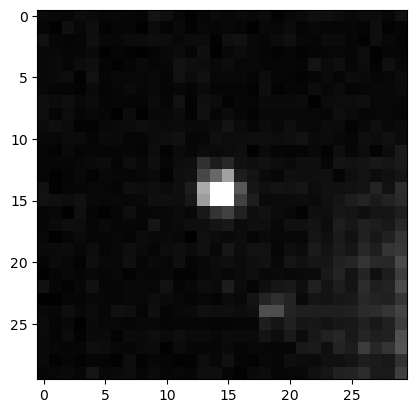

In [427]:
starList.displayStar(209, mode='zoom')

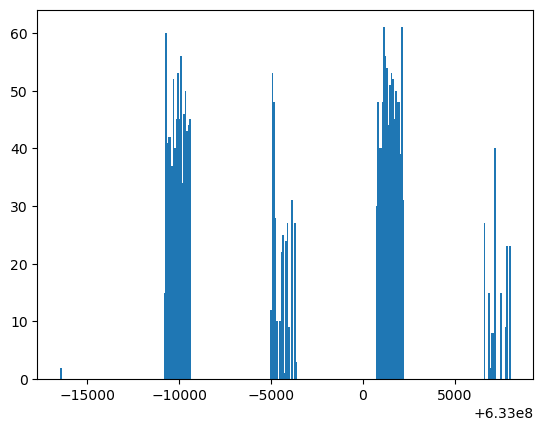

In [426]:
starData = getData(stars[209])
plt.hist(starData['TIME'], bins=300)
plt.show()

In [417]:
starData

array([(6.32983552e+08, 1061, 1131, 1933, 1971, 2743, 1766, 1, 0),
       (6.32989252e+08,  833, 1945, 1784, 1190, 2742, 1768, 2, 0),
       (6.32989335e+08,  561, 1253, 1786, 1202, 2744, 1768, 2, 0), ...,
       (6.33006973e+08, 1553, 1894, 1586, 1985, 2772, 1791, 5, 0),
       (6.33007488e+08, 1539, 1912, 1588, 1985, 2773, 1790, 5, 0),
       (6.33008023e+08, 1054, 1904, 1588, 1983, 2771, 1790, 5, 0)],
      dtype=[('TIME', '<f8'), ('RAWX', '<i2'), ('RAWY', '<i2'), ('DETX', '<i2'), ('DETY', '<i2'), ('X', '<i2'), ('Y', '<i2'), ('EXPREF', '<i2'), ('QUALITY', '<i2')])

In [431]:
r, mt = getSignals(5, starData['TIME'], False)

In [435]:
# for i in range(len(r)):
#     print(i, r[i], mt[i])

amp 92.91022137549588 mean -0.01649145951377107 stdev -0.10374074380173227


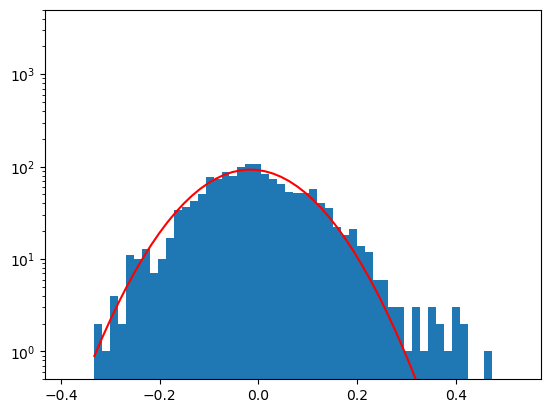

(-0.004309393483489625, 0.11273221662218186, 0.5593516896274197)

In [433]:
visualizeSignals(r, 50)

In [420]:
unusualSignalInfo(r, mt, 1, False)

index 254 with ratio 1.2671483214985046 at time 632995212


window 5
amp 90.92900778465106 mean -0.0027897854096474326 stdev 0.6974162884856157


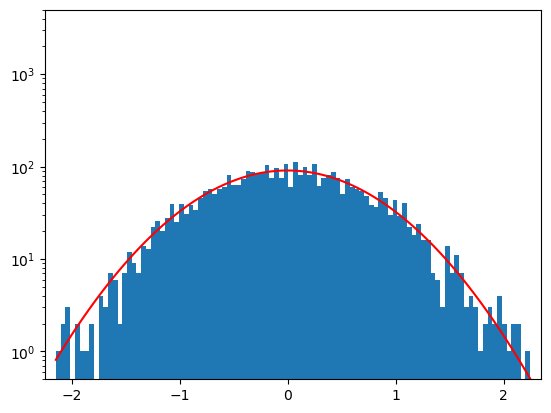

window 6
amp 105.1532691438691 mean -0.00537233711075473 stdev 0.5500722115668426


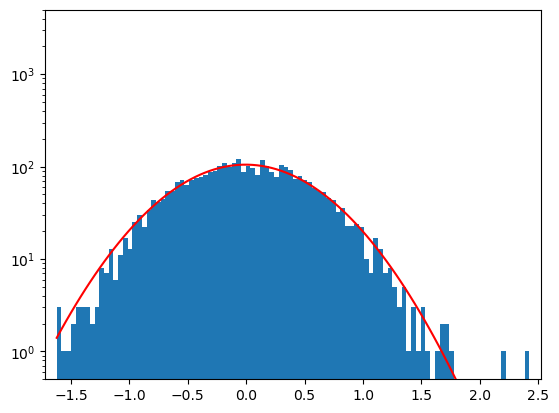

window 7
amp 107.26980413699592 mean -0.004529867491015352 stdev -0.4367036400123238


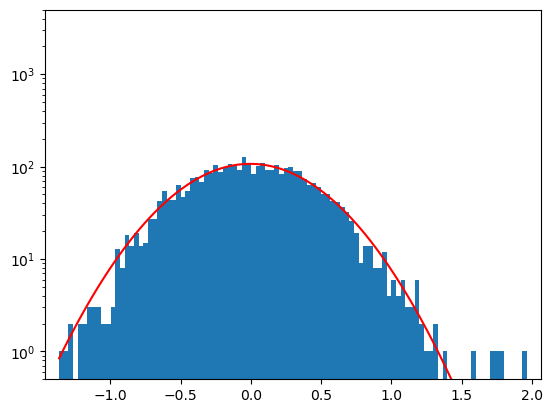

window 8
amp 46.70733209579241 mean 0.0025472732977097463 stdev 0.3643311365269919


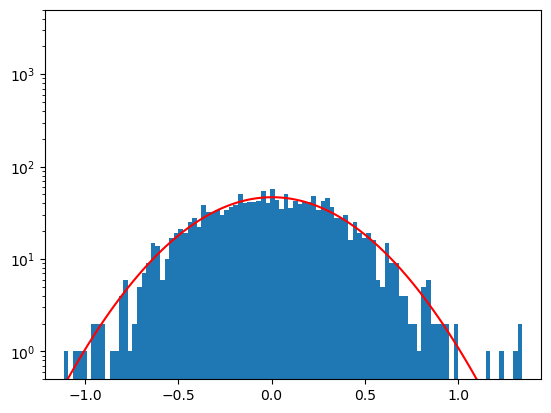

window 9
amp 48.294029415476906 mean 0.004350141111709987 stdev 0.3009237234825295


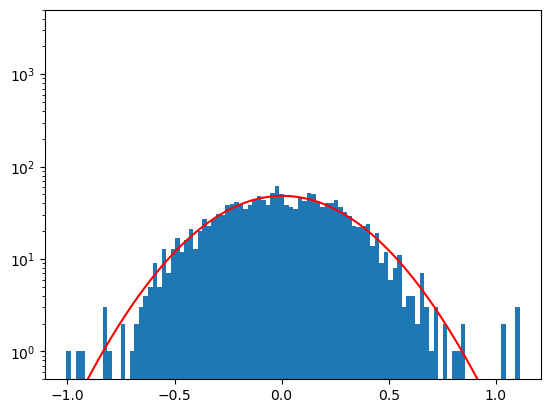

window 10
amp 50.65921544354785 mean 0.005900046712655146 stdev 0.2612154004740303


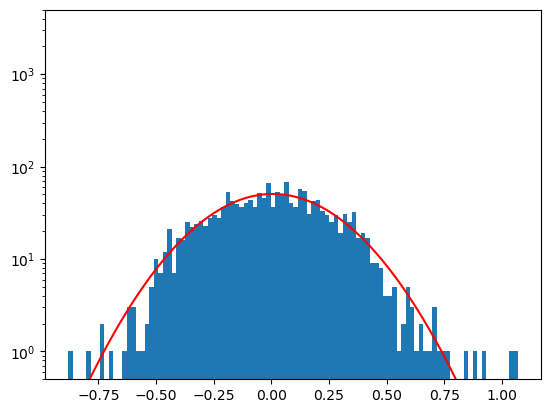

window 11
amp 51.87011973733326 mean 0.011317410584167254 stdev 0.22615347728301358


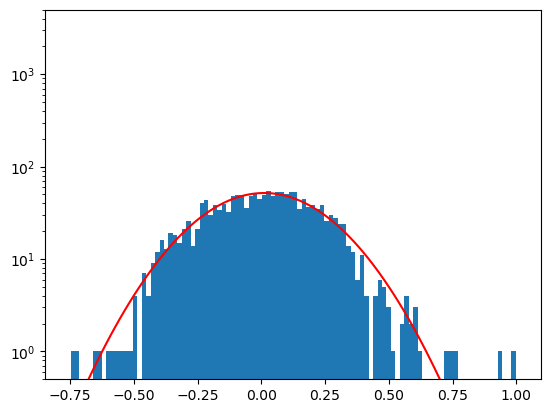

window 12
amp 30.121205931164013 mean 0.012253109263045046 stdev 0.1991065409452367


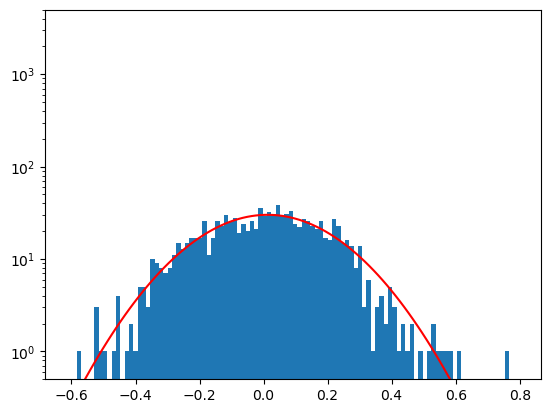

window 13
amp 29.41273195633788 mean 0.008057302313470892 stdev 0.17966357166036157


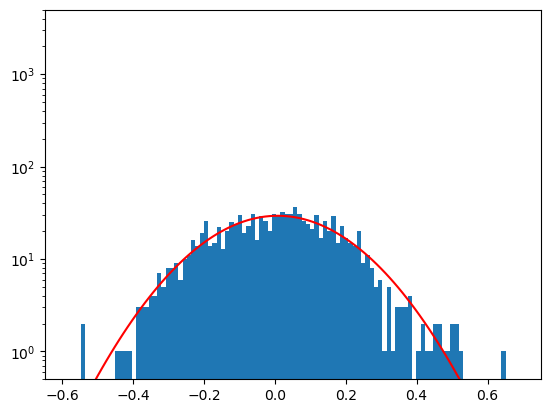

window 14
amp 31.000627831794983 mean 0.004466632404399262 stdev 0.15706233536596154


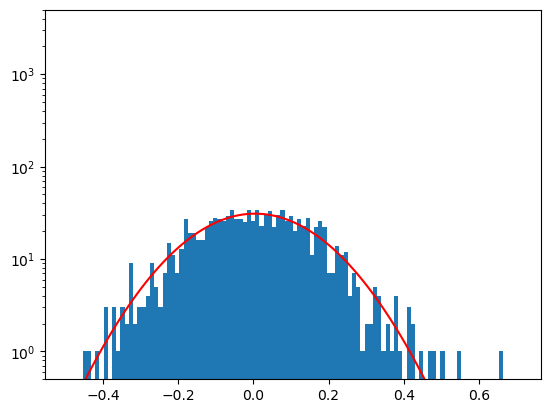

window 15
amp 29.351431723650393 mean 0.0035952175842713686 stdev 0.13987785370475955


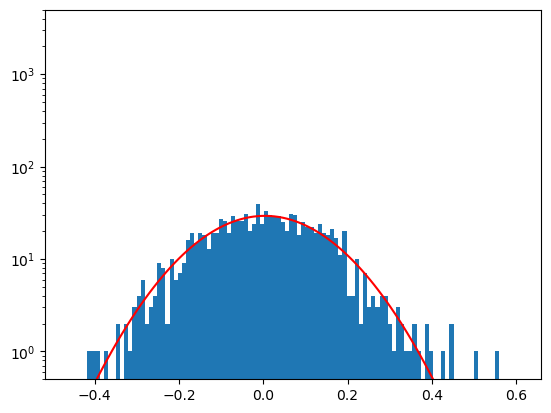

window 16
amp 19.74595862967631 mean 0.0038291104997375783 stdev 0.1273714294802656


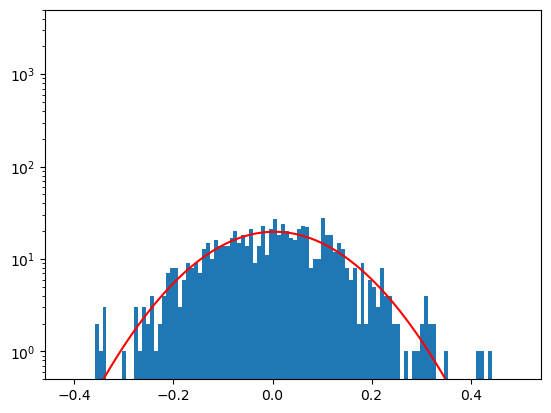

window 17
amp 22.816344799259664 mean 0.0007562271224614876 stdev 0.11751560789409626


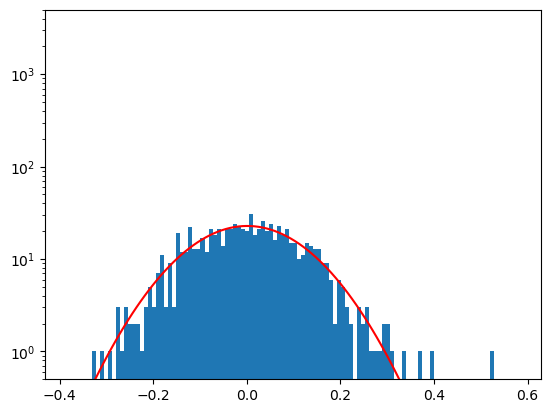

window 18
amp 21.35679853106697 mean 0.0023117842464734297 stdev 0.10995645388917424


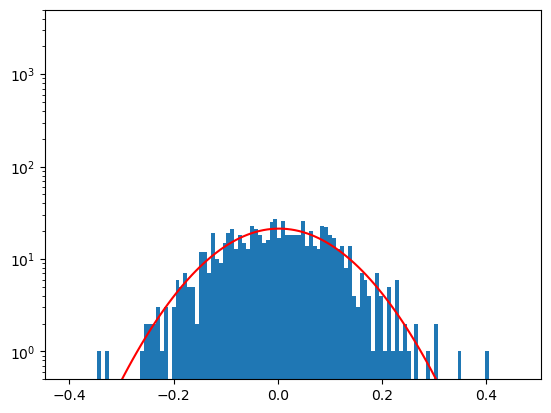

window 19
amp 18.351744539871788 mean 0.0008949647230744875 stdev 0.10157348053665423


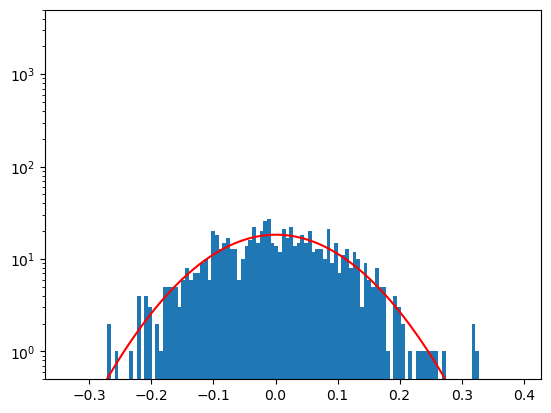

window 20
amp 14.496342887767405 mean 0.0020272018352662322 stdev 0.09577393276306974


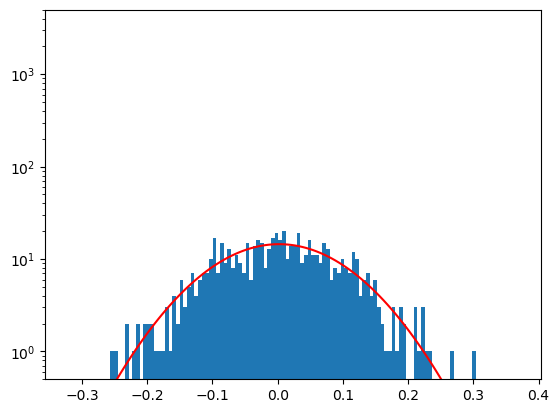

window 21
amp 13.795923455447127 mean 0.001902243212323403 stdev -0.09021634774779336


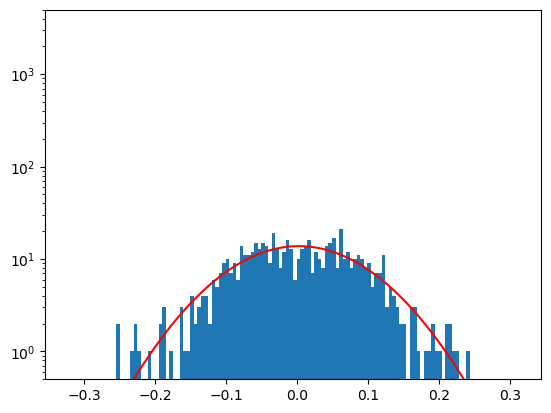

window 22
amp 13.703774734279504 mean 0.00031033891810744533 stdev -0.08593075092717009


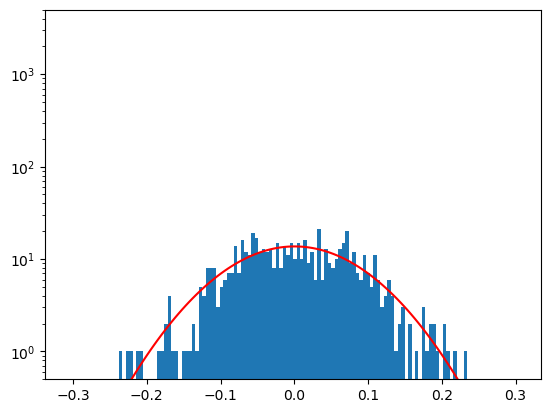

window 23
amp 13.45508917497172 mean 0.0022407967912591842 stdev 0.08165852088215307


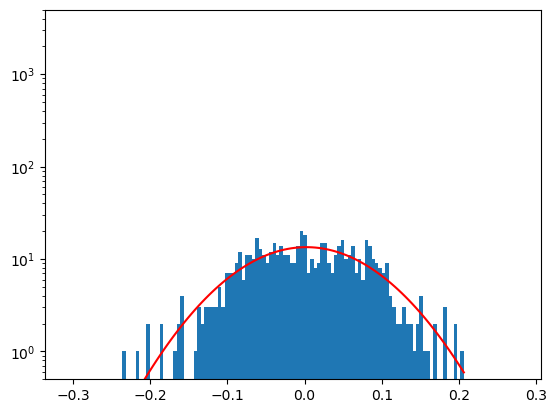

window 24
amp 11.403178649766845 mean 0.001456127829066646 stdev -0.07586127562111425


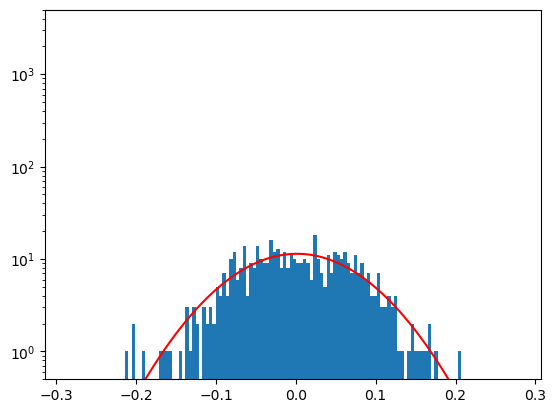

window 25
amp 10.215614631153311 mean 0.00228017452930286 stdev -0.07280247498242239


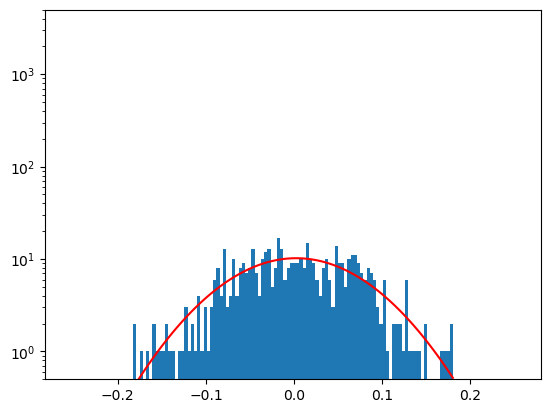

window 26
amp 10.797293027933769 mean 0.0012540139528858247 stdev 0.06904652599667438


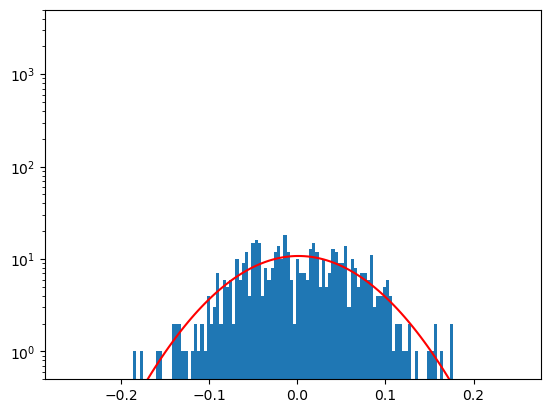

window 27
amp 107.21143917637357 mean 0.006375470081867766 stdev 0.06479115546070871


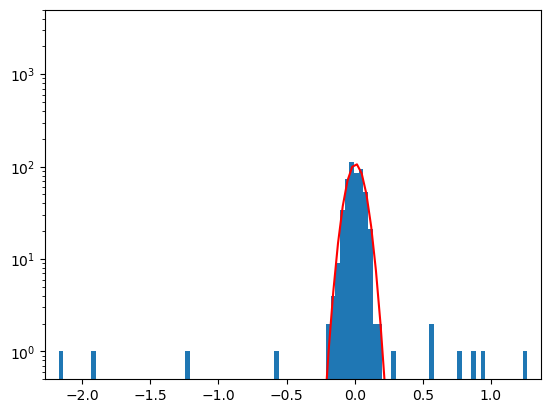

window 28
amp 83.65911129139646 mean 0.007931497928358669 stdev 0.06239622858571181


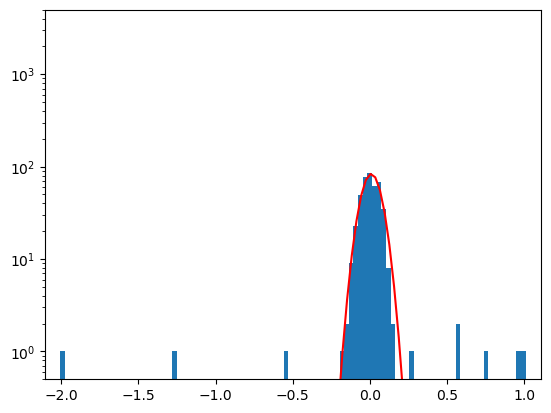

window 29
amp 89.88788623856696 mean 0.006245397641348811 stdev 0.05825327553623516


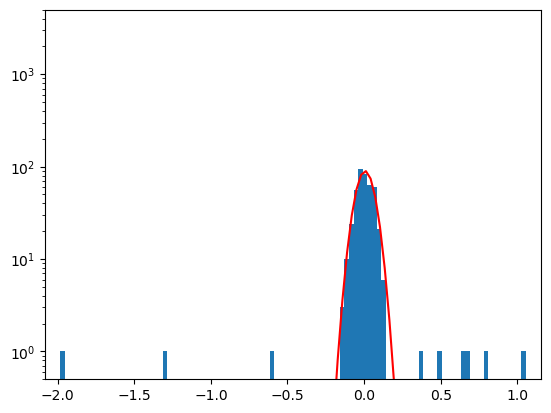

dict_keys([27, 28, 29])

In [396]:
analyzeStar(starData['TIME'])

In [421]:
d = splitInterval(starData['TIME'])
e = np.array(d[1], dtype=[('TIME', '>f8')])

In [423]:
print('ratio', calculateRatio(27, 632995212, starData['TIME'], True))

signalCounts 1191 signalArea 27
bgCounts 2321 bgArea 81.0
bgMean 28.65432098765432 signal 15.456790123456795 totalNoise 12.198090674324455
ratio 1.2671483214985046


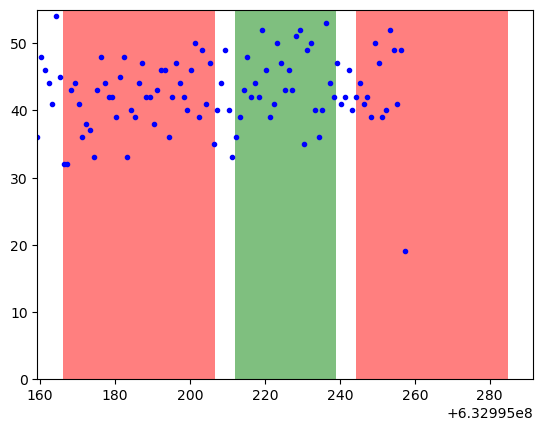

  time_bin_start  time_bin_size num_events
                        s                 
----------------- ------------- ----------
632995159.3508201           1.0         36
632995160.3508201           1.0         48
632995161.3508201           1.0         46
632995162.3508201           1.0         44
632995163.3508201           1.0         41
632995164.3508201           1.0         54
              ...           ...        ...
632995251.3508201           1.0         39
632995252.3508201           1.0         40
632995253.3508201           1.0         52
632995254.3508201           1.0         49
632995255.3508201           1.0         41
632995256.3508201           1.0         49
632995257.3508201           1.0         19
Length = 99 rows


In [425]:
print(visualizeStarTS(e, binsize=1, windowSize=27, windowStart=632995212, point=True))

In [146]:
## Not very useful (for now)

# plt.hist(events_clean['TIME']-633000000, bins=1000)
# plt.axvline(x=7709, c='r')
# plt.xlim(6000, 8500)
# plt.show()

In [210]:
a = splitInterval(starData['TIME'], 12)

In [211]:
b = 1000
b = [min(b, a[i][-1] - a[i][0]) for i in range(len(a))]

(array([131., 117., 127., 118., 112., 122., 140., 120., 109., 132.]),
 array([6.32989220e+08, 6.32989362e+08, 6.32989504e+08, 6.32989646e+08,
        6.32989788e+08, 6.32989930e+08, 6.32990072e+08, 6.32990214e+08,
        6.32990356e+08, 6.32990498e+08, 6.32990640e+08]),
 <BarContainer object of 10 artists>)

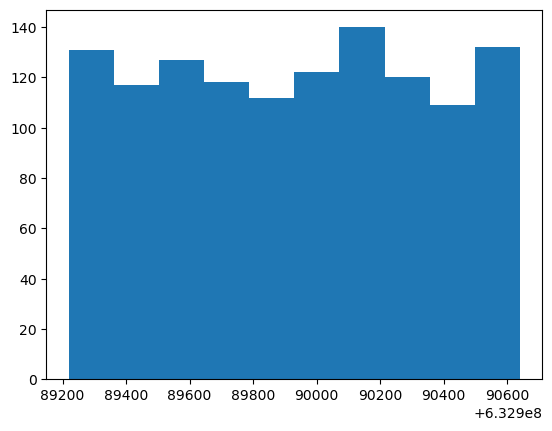

In [212]:
plt.hist(a)

In [215]:
a

[array([6.32989220e+08, 6.32989221e+08, 6.32989222e+08, ...,
        6.32990638e+08, 6.32990638e+08, 6.32990640e+08])]